In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from kmodes.kmodes import KModes

In [2]:
# Reading CSV Files
df_act_3060 = pd.read_csv('../data/DATA0113/DATA/AGE3060/DLAB_HT_L1_ACT_IFO_TMP_3060.csv')
df_trd_3060 = pd.read_csv('../data/DATA0113/DATA/AGE3060/DLAB_INTERN_TR_IFO_TMP3_3060.csv')
df_cus_3060 = pd.read_csv('../data/DATA0113/DATA/AGE3060/DLAB_HT_L1_CUS_IFO_TMP_3060.csv')

df_act_1030 = pd.read_csv('../data/DATA0113/DATA/AGE1030/DLAB_HT_L1_ACT_IFO_TMP_1030.csv')
df_trd_1030 = pd.read_csv('../data/DATA0113/DATA/AGE1030/DLAB_INTERN_TR_IFO_TMP_1030.csv')
df_cus_1030 = pd.read_csv('../data/DATA0113/DATA/AGE1030/DLAB_HT_L1_CUS_IFO_TMP_1030.csv')
df_trd_2_1030 = pd.read_csv('../data/DATA0113/DATA/AGE1030/DLAB_INTERN_TR_IFO_TMP2_1030.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [9]:
df_act_3060.shape # (2253 ,4)
df_trd_3060.shape # (2089791, 10)
df_cus_3060.shape # (1000,7)
df_act_1030.shape # (844, 4)
df_trd_1030.shape # (286681,10)
df_cus_1030.shape # (500, 7)
df_trd_2_1030.shape # (404369,10)


(404369, 10)

In [3]:
# Changing the index of the csv files
df_trd_3060 = df_trd_3060.drop(columns = ['Unnamed: 0'])
df_act_3060 = df_act_3060.drop(columns = ['Unnamed: 0'])
df_cus_3060 = df_cus_3060.drop(columns = ['Unnamed: 0'])

df_trd_1030 = df_trd_1030.drop(columns = ['Unnamed: 0'])
df_act_1030 = df_act_1030.drop(columns = ['Unnamed: 0'])
df_cus_1030 = df_cus_1030.drop(columns = ['Unnamed: 0'])
df_trd_2_1030 = df_trd_2_1030.drop(columns = ['Unnamed: 0'])

In [4]:
df_trd_2_1030 = df_trd_2_1030[df_trd_2_1030['iqr_dt'] > 20210701]
df_trd_1030 = pd.concat([df_trd_1030, df_trd_2_1030])

In [5]:
# Making and cleaning data set to cluster for 3060
df_bal = df_trd_3060.copy()[['iqr_dt', 'cus_no', 'tot_aet_amt']].groupby(['iqr_dt', 'cus_no']).sum()
df_bal = df_bal.reset_index()

df_bal_kor = df_trd_3060[df_trd_3060['mkt_gb'] == '국내'].copy()[['iqr_dt', 'cus_no', 'tot_aet_amt']].groupby(['iqr_dt', 'cus_no']).sum()
df_bal_kor = df_bal_kor.reset_index()

df_bal_ovs = df_trd_3060[df_trd_3060['mkt_gb'] == '해외'].copy()[['iqr_dt', 'cus_no', 'tot_aet_amt']].groupby(['iqr_dt', 'cus_no']).sum()
df_bal_ovs = df_bal_ovs.reset_index()

df_bal_tot = pd.merge(left=df_bal, 
                      right=df_bal_kor[['iqr_dt','cus_no', 'tot_aet_amt']], 
                      on=['cus_no', 'iqr_dt'], 
                      suffixes=('', '_kr'), 
                      how='left')
df_bal_tot = pd.merge(left=df_bal_tot, 
                      right=df_bal_ovs[['iqr_dt','cus_no', 'tot_aet_amt']], 
                      on=['cus_no', 'iqr_dt'], 
                      suffixes=('', '_ov'), 
                      how='left')

df_bal_tot[['tot_aet_amt_kr', 'tot_aet_amt_ov']] = df_bal_tot[['tot_aet_amt_kr', 'tot_aet_amt_ov']].fillna(0)

bank_cus_3060 = pd.merge(left=df_cus_3060, right = df_bal_tot, on='cus_no', suffixes=('',''))
bank_cus_3060['ovs_ratio'] = bank_cus_3060['tot_aet_amt_ov']/bank_cus_3060['tot_aet_amt']

In [6]:
# Making and cleaning data set to cluster for 1030
df_bals = df_trd_1030.copy()[['iqr_dt', 'cus_no', 'tot_aet_amt']].groupby(['iqr_dt', 'cus_no']).sum()
df_bals = df_bals.reset_index()

df_bal_kors = df_trd_1030[df_trd_1030['mkt_gb'] == '국내'].copy()[['iqr_dt', 'cus_no', 'tot_aet_amt']].groupby(['iqr_dt', 'cus_no']).sum()
df_bal_kors = df_bal_kors.reset_index()

df_bal_ov = df_trd_1030[df_trd_1030['mkt_gb'] == '해외'].copy()[['iqr_dt', 'cus_no', 'tot_aet_amt']].groupby(['iqr_dt', 'cus_no']).sum()
df_bal_ov = df_bal_ov.reset_index()

df_bal_tots = pd.merge(left=df_bals, 
                      right=df_bal_kors[['iqr_dt','cus_no', 'tot_aet_amt']], 
                      on=['cus_no', 'iqr_dt'], 
                      suffixes=('', '_kr'), 
                      how='left')
df_bal_tots = pd.merge(left=df_bal_tots, 
                      right=df_bal_ov[['iqr_dt','cus_no', 'tot_aet_amt']], 
                      on=['cus_no', 'iqr_dt'], 
                      suffixes=('', '_ov'), 
                      how='left')

df_bal_tots[['tot_aet_amt_kr', 'tot_aet_amt_ov']] = df_bal_tots[['tot_aet_amt_kr', 'tot_aet_amt_ov']].fillna(0)

bank_cus_1030 = pd.merge(left=df_cus_1030, right = df_bal_tots, on='cus_no', suffixes=('',''))
bank_cus_1030['ovs_ratio'] = bank_cus_1030['tot_aet_amt_ov']/bank_cus_1030['tot_aet_amt']

In [7]:
# Getting the 3060 data for 20210701
bank_cus_3060 = bank_cus_3060[bank_cus_3060['iqr_dt'] == 20211231]
bank_cus_3060.head() 

# Getting the 1030 data for 20210701
bank_cus_1030 = bank_cus_1030[bank_cus_1030['iqr_dt'] == 20211231]
bank_cus_1030.head()

# Combining 1030 and 3060 data for 20210701
bank_cus_combined = pd.concat([bank_cus_1030, bank_cus_3060])

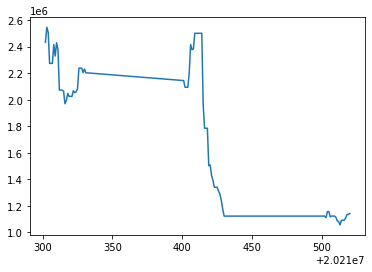

In [8]:
df = df_trd_1030[df_trd_1030['iem_krl_anm'] == '카카오']
kakao = (df.groupby('iqr_dt').sum()['tot_aet_amt'] / df.groupby('iqr_dt').count()['tot_aet_amt']).reset_index()
bla = kakao[kakao['iqr_dt'] > 20210301][:80]
plt.plot(bla['iqr_dt'], bla['tot_aet_amt'])


In [9]:
r = np.array([0,29, 40, 54, 70])
bank_cus_ovs = bank_cus_combined.groupby(pd.cut(bank_cus_combined['cus_age'], r)).mean()
bank_cus_ovs

# bank_cus_ovs[['cus_age','ovs_ratio']].groupby('cus_age').mean()
#10.23

,cus_no,sex_dit_cd,cus_age,iqr_dt,tot_aet_amt,tot_aet_amt_kr,tot_aet_amt_ov,ovs_ratio
cus_age,,,,,,,,
"(0, 29]",1.023968e+08,1.522523,23.923423,20211231.0,8.250433e+06,6.953354e+06,1.297079e+06,0.131315
"(29, 40]",1.033289e+08,1.536866,34.235023,20211231.0,1.968893e+07,1.674846e+07,2.940463e+06,0.148638
"(40, 54]",9.361713e+07,1.535637,47.373650,20211231.0,3.910417e+07,3.691039e+07,2.193787e+06,0.050892
"(54, 70]",7.713122e+07,1.429530,57.255034,20211231.0,6.732612e+07,6.552534e+07,1.800784e+06,0.041202


In [10]:
# Shrinking combined data to cluster 초기화면
bank_cus_cluster = bank_cus_combined.drop(columns=['iqr_dt','tot_aet_amt','tot_aet_amt_kr','tot_aet_amt_ov', 'ovs_ratio','tco_cus_grd_cd'])
bank_cus_cluster.head()

,cus_no,sex_dit_cd,cus_age,zip_ctp_cd,ivs_icn_cd
364,103139301,2,29,44,02
708,102997409,2,27,11,04
1059,103481357,2,30,31,-
1291,104565295,2,25,28,03
1656,102932829,2,28,11,03


In [11]:
# Choosing K using elbow method
cost = []
for clusters in list(range(1,10)):
    modes = KModes(n_clusters=clusters, init = "Random", n_init=5, verbose=1)
    modes.fit_predict(bank_cus_cluster)
    cost.append(modes.cost_)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 5510.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 0, cost: 5510.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 0, cost: 5510.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 0, cost: 5510.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 0, cost: 5510.0
Best run was number 1
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 41, cost: 5313.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 125, cost: 4898.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...

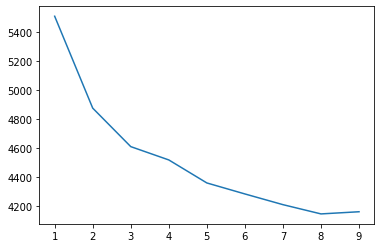

In [12]:
#Graphing the elbow
graph = np.array([i for i in range (1,10,1)])
plt.plot(graph, cost)

# 6 seems to be the optimal K value

In [13]:
# KModes clustering ran 10 times with K=6
km = KModes(n_clusters=6, init="Random", n_init=10, verbose=1)
fit_clusters = km.fit_predict(bank_cus_cluster)


Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 303, cost: 4344.0
Run 1, iteration: 2/100, moves: 0, cost: 4344.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 93, cost: 4414.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 168, cost: 4500.0
Run 3, iteration: 2/100, moves: 3, cost: 4500.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 237, cost: 4571.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 532, cost: 4415.0
Run 5, iteration: 2/100, moves: 130, cost: 4360.0
Run 5, iteration: 3/100, moves: 1, cost: 4360.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 6, iteration: 1/100, moves: 335, cost: 4407.0
Run 6, iteration: 2/100, mo

In [36]:
# Input the predicted group into original data
bank_cus_cluster['cluster'] = fit_clusters

# Cleaning out the data and finding the mean of the clusters
bank_cus_cluster['zip_ctp_cd'] = bank_cus_cluster['zip_ctp_cd'].fillna(0)
bank_cus_cluster['zip_ctp_cd'] = bank_cus_cluster['zip_ctp_cd'].replace('-',0).astype(int)
bank_cus_cluster['ivs_icn_cd'] = bank_cus_cluster['ivs_icn_cd'].fillna(0)
bank_cus_cluster['ivs_icn_cd'] = bank_cus_cluster['ivs_icn_cd'].replace('-',0).astype(int)

df_mean = bank_cus_cluster.groupby('cluster').mean()
df_mean


bank_cus_cluster[['cluster','zip_ctp_cd']].groupby('zip_ctp_cd').count()


,cluster
zip_ctp_cd,
0,9
11,312
26,87
27,59
28,74
29,36
30,52
31,37
36,10


In [28]:
bank_cus_cluster.to_csv('./bank_cus_cluster.csv')

In [46]:
bank_cus_cluster['zip_ctp_cd'] = bank_cus_cluster['zip_ctp_cd'].replace('경기', ' ').replace('서울', '   ')

bank_cus_cluster    

,cus_no,sex_dit_cd,cus_age,zip_ctp_cd,ivs_icn_cd,cluster
364,103139301,2,29,44,2,5
708,102997409,2,27,,4,0
1059,103481357,2,30,31,0,0
1291,104565295,2,25,28,3,0
1656,102932829,2,28,,3,0
1872,102099686,2,28,,0,2
2051,103087006,2,26,30,0,2
2084,7363951,1,29,,4,1
2446,103242051,1,26,28,3,0
2634,103067802,2,25,26,4,0


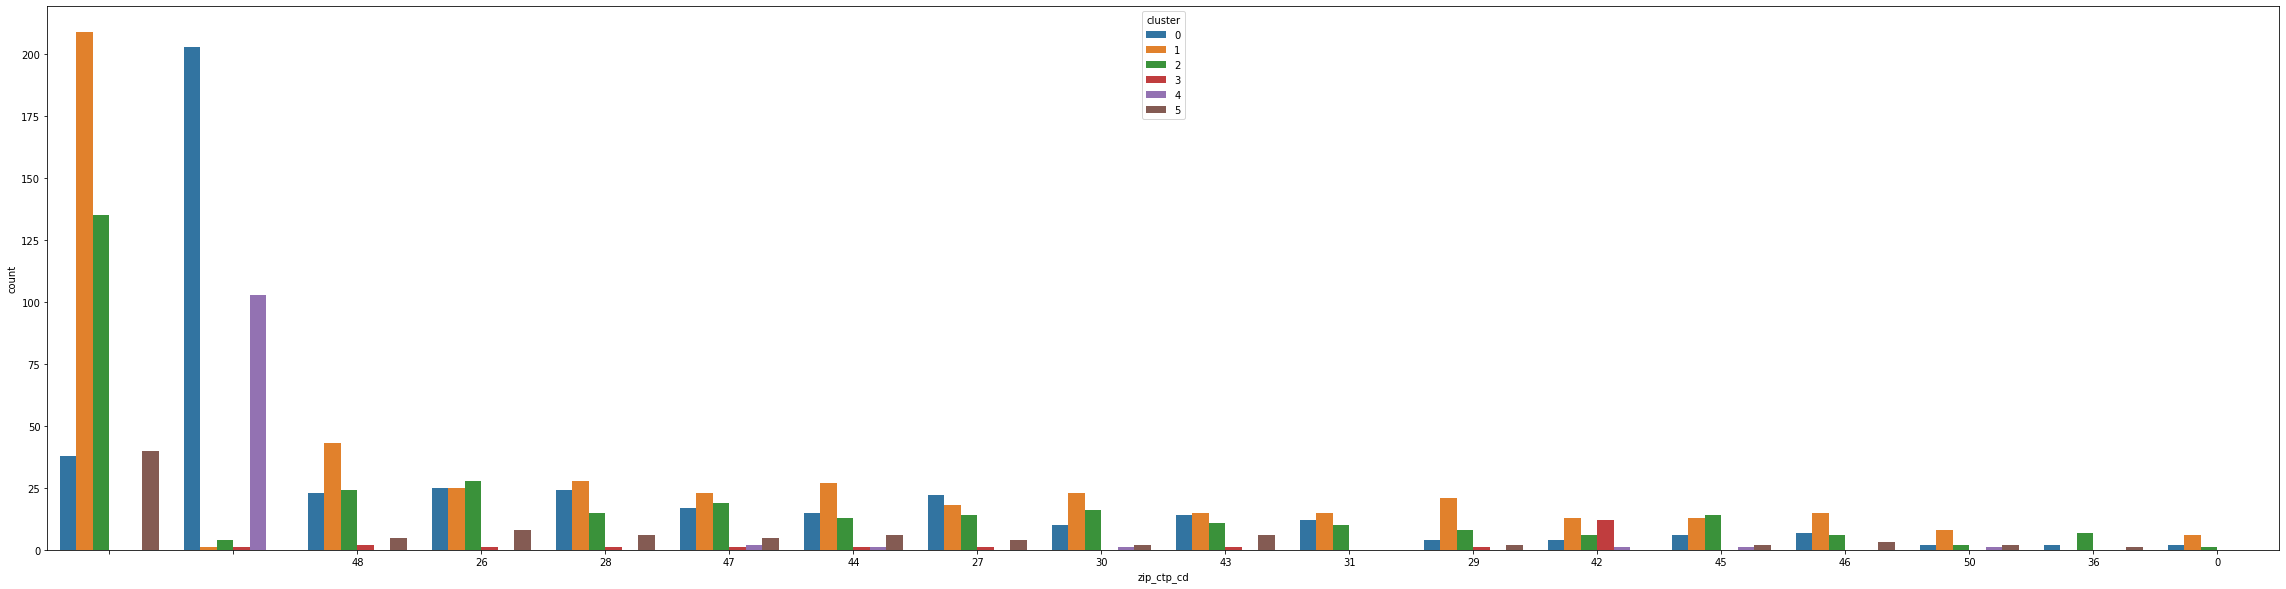

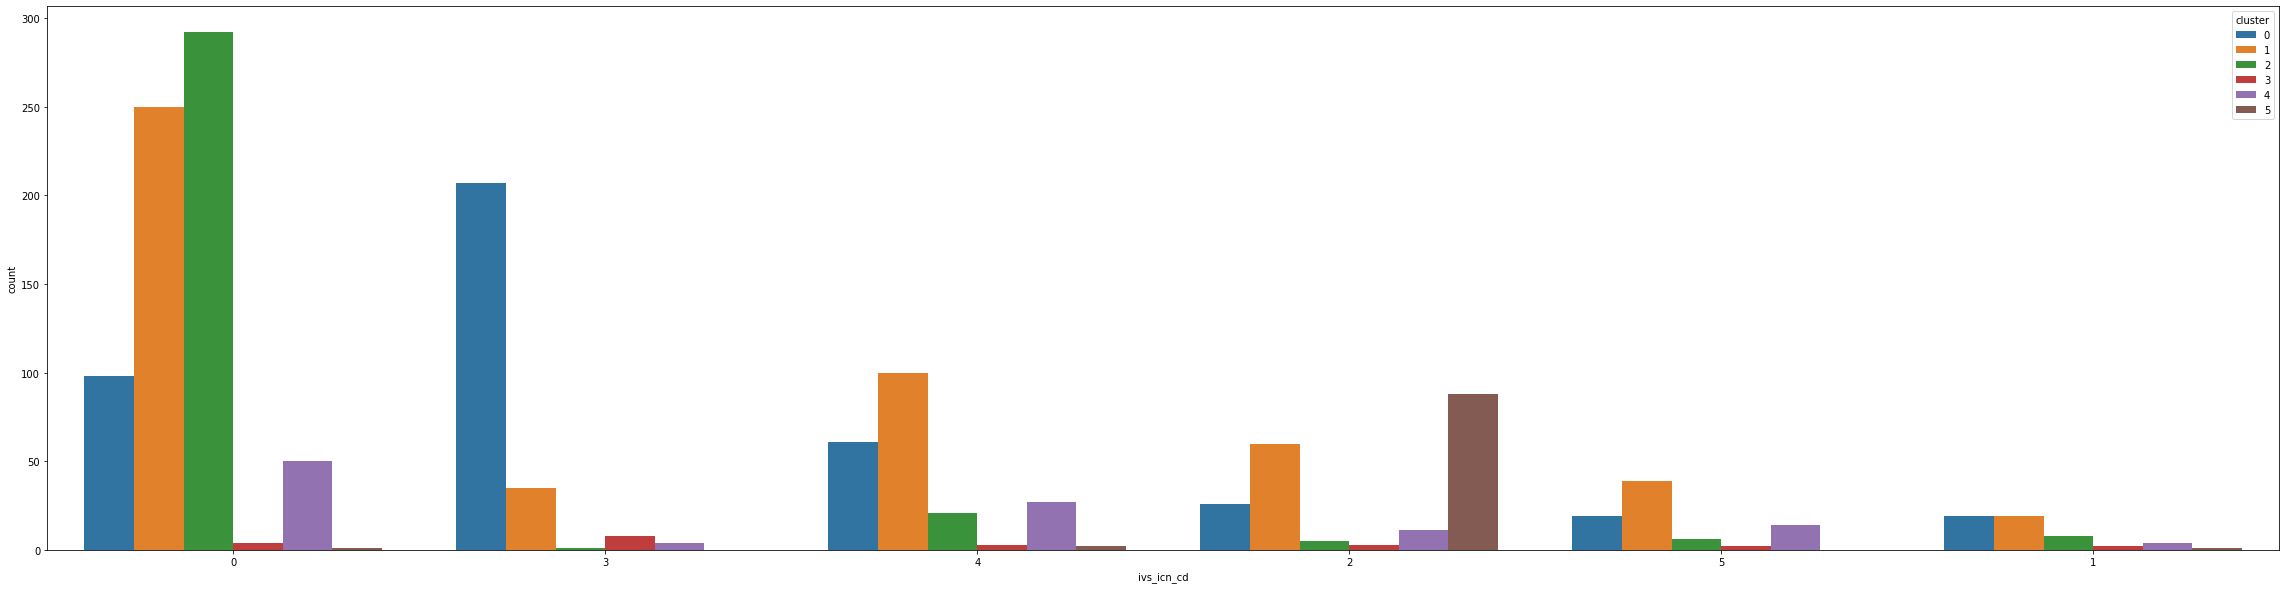

In [51]:
# ZIP code and ivs_icn_cd graph
plt.subplots(figsize= (40,10))
sns.countplot(x=bank_cus_cluster['zip_ctp_cd'], order=bank_cus_cluster['zip_ctp_cd'].value_counts().index, hue=bank_cus_cluster['cluster'])
plt.show()

plt.subplots(figsize= (40,10))
sns.countplot(x=bank_cus_cluster['ivs_icn_cd'], order=bank_cus_cluster['ivs_icn_cd'].value_counts().index, hue=bank_cus_cluster['cluster'])
plt.show()

In [16]:
#Combined trd
df_trd_combined = pd.concat([df_trd_1030, df_trd_3060])

In [17]:
# Function to print top 5 관심종목
def top_5(n):
    df = bank_cus_cluster[bank_cus_cluster['cluster'] == n].reset_index()
    table_0 = df_trd_combined[(df_trd_combined['iqr_dt'] == 20211231) & (df_trd_combined['cus_no'].isin(df['cus_no']))].groupby('iem_krl_anm').count().sort_values(by='iqr_dt', ascending=False).head()/bank_cus_cluster.groupby('cluster').count()['cus_no'][i]
    table_0 = table_0.drop(columns =['iqr_dt', 'cus_no', 'act_no','mkt_gb','pdt_gb','iem_cd','tot_aet_amt'])
    table_0[n] = table_0['bnc_qty']
    table_0 = table_0.drop(columns=['bnc_qty'])
    return display(table_0)
    
# Printing top 5 for each group
for i in range(6):
    top_5(i)

,0
iem_krl_anm,
삼성전자,0.465116
카카오,0.202326
삼성전자우,0.120930
현대차,0.113953
대한항공,0.095349


,1
iem_krl_anm,
삼성전자,0.343936
카카오,0.083499
삼성전자우,0.077535
현대차,0.065606
대한항공,0.049702


,2
iem_krl_anm,
삼성전자,0.486486
카카오,0.183183
삼성전자우,0.117117
대한항공,0.108108
SK하이닉스,0.087087


,3
iem_krl_anm,
삼성전자,0.409091
두산중공업,0.227273
카카오,0.227273
SK하이닉스,0.136364
에이치엘비생명과학,0.136364


,4
iem_krl_anm,
삼성전자,0.409091
카카오,0.145455
현대차,0.118182
삼성전자우,0.100000
SK하이닉스,0.090909


,5
iem_krl_anm,
삼성전자,0.489130
삼성전자우,0.184783
카카오,0.173913
애플,0.108696
현대차,0.097826


In [18]:
bank_cluster_DB = bank_cus_cluster[['cus_no', 'cluster']]
bank_cluster_DB

,cus_no,cluster
364,103139301,5
708,102997409,0
1059,103481357,0
1291,104565295,0
1656,102932829,0
1872,102099686,2
2051,103087006,2
2084,7363951,1
2446,103242051,0
2634,103067802,0


In [19]:
# Trying to cluster with all the given data
bank_cus_cluster_all = bank_cus_combined.drop(columns=['tco_cus_grd_cd', 'iqr_dt'])
bank_cus_cluster_all.head()

# Cleaning out the data 
bank_cus_cluster_all['zip_ctp_cd'] = bank_cus_cluster['zip_ctp_cd'].fillna(0)
bank_cus_cluster_all['zip_ctp_cd'] = bank_cus_cluster['zip_ctp_cd'].replace('-',0).astype(int)
bank_cus_cluster_all['ivs_icn_cd'] = bank_cus_cluster['ivs_icn_cd'].fillna(0)
bank_cus_cluster_all['ivs_icn_cd'] = bank_cus_cluster['ivs_icn_cd'].replace('-',0).astype(int)                                                                              

In [20]:
# Choosing K using elbow method
costs = []
for clusters in list(range(1,10)):
    modes = KModes(n_clusters=clusters, init = "Random", n_init=5, verbose=1)
    modes.fit_predict(bank_cus_cluster_all)
    costs.append(modes.cost_)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 8980.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 0, cost: 8980.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 0, cost: 8980.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 0, cost: 8980.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 0, cost: 8980.0
Best run was number 1
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 575, cost: 8383.0
Run 1, iteration: 2/100, moves: 76, cost: 8383.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 542, cost: 8332.0
Run 2, iteration: 2/100, move

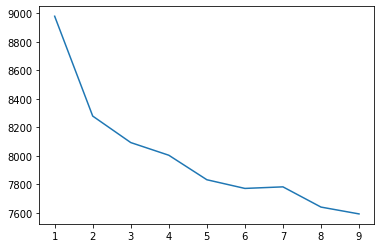

In [21]:
#Graphing the elbow
graphs = np.array([i for i in range (1,10,1)])
plt.plot(graphs, costs)

# 5 seems to be the optimal K value

In [22]:
# KModes clustering ran 10 times with K=5
km = KModes(n_clusters=5, init="Random", n_init=10, verbose=1)
fit_cluster = km.fit_predict(bank_cus_cluster)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 275, cost: 4448.0
Run 1, iteration: 2/100, moves: 86, cost: 4448.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 370, cost: 4700.0
Run 2, iteration: 2/100, moves: 77, cost: 4695.0
Run 2, iteration: 3/100, moves: 1, cost: 4695.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 369, cost: 4480.0
Run 3, iteration: 2/100, moves: 55, cost: 4480.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 52, cost: 4464.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 168, cost: 4663.0
Run 5, iteration: 2/100, moves: 11, cost: 4663.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 6, iteration: 1/100, mo

In [23]:
bank_cus_cluster_all.groupby('cluster').count()

KeyError: 'cluster'

In [ ]:
# Input the predicted group into original data
bank_cus_cluster_all['cluster'] = fit_clusters

# Get mean
df_means = bank_cus_cluster_all.groupby('cluster').mean()
df_means

In [ ]:
# Function to print top 5 관심종목
def top_5_0(n):
    df = bank_cus_cluster_all[bank_cus_cluster_all['cluster'] == n].reset_index()
    table_0 = df_trd_combined[(df_trd_combined['iqr_dt'] == 20210701) & (df_trd_combined['cus_no'].isin(df['cus_no']))].groupby('iem_krl_anm').count().sort_values(by='iqr_dt', ascending=False).head()/bank_cus_cluster.groupby('cluster').count()['cus_no'][i]
    table_0 = table_0.drop(columns =['iqr_dt', 'cus_no', 'act_no','mkt_gb','pdt_gb','iem_cd','tot_aet_amt'])
    table_0[n] = table_0['bnc_qty']
    table_0 = table_0.drop(columns=['bnc_qty'])
    return display(table_0)
    
# Printing top 5 for each group
for i in range(6):
    top_5_0(i)